<a href="https://colab.research.google.com/github/Melo95/ML_course_Pavia_23/blob/v2/ML_PhD_course_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import libraries



In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras.models import Model
from google.colab import drive
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Try to connect to my drive account

In [ ]:
# drive.mount('/content/drive')

# # Upload training data
# uploaded = files.upload()

In [2]:
# Model / data parameters
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets however for out purpose the labels (y_...) are not important!
(x_train_MNIST, y_train_MNIST), (x_test_MNIST, y_test_MNIST) = keras.datasets.mnist.load_data()
(x_train_fMNIST, y_train_fMNIST), (x_test_fMNIST, y_test_fMNIST) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train_MNIST = x_train_MNIST.astype("float32") / 255
x_test_MNIST = x_test_MNIST.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_MNIST = np.expand_dims(x_train_MNIST, -1)
x_test_MNIST = np.expand_dims(x_test_MNIST, -1)
print("x_train_MNIST shape:", x_train_MNIST.shape)
print(x_train_MNIST.shape[0], "train samples")
print(x_test_MNIST.shape[0], "test samples")

# Scale images to the [0, 1] range
x_train_fMNIST = x_train_fMNIST.astype("float32") / 255
x_test_fMNIST = x_test_fMNIST.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_fMNIST = np.expand_dims(x_train_fMNIST, -1)
x_test_fMNIST = np.expand_dims(x_test_fMNIST, -1)
print("x_train_fMNIST shape:", x_train_fMNIST.shape)
print(x_train_fMNIST.shape[0], "train samples")
print(x_test_fMNIST.shape[0], "test samples")

4422102/4422102 [==============================] - 0s 0us/step
x_train_MNIST shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
x_train_fMNIST shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

In [28]:
# create mask
x = np.arange(-x_train_MNIST.shape[1]/2,x_train_MNIST.shape[1]/2,1)
y = np.arange(-x_train_MNIST.shape[1]/2,x_train_MNIST.shape[1]/2,1)

X,Y = np.meshgrid(x,y)

# prb_circular = 1/(X**2+Y**2)*np.exp(1j*(X+Y))

A = 1 # Gaussian height
sigma = 10
prb_gaussian = A* np.exp(-(X**2 + Y**2)/2/sigma**2) #se metto un fattore di fase qui, il valore assoluto del pattern di diffrazione mi diventa complesso... boh! *np.exp(1j*(X+Y))

mask = create_circular_mask(prb_gaussian.shape[0],prb_gaussian.shape[1], center = None, radius = 14)

complex_mask = mask*np.exp(1j*mask)
complex_prb = prb_gaussian*complex_mask

complex_prb_amplitude = np.abs(complex_prb)
complex_prb_phase = np.angle(complex_prb)
complex_prb_phase[complex_prb_amplitude == 0] = 0

updated_complex_prb = complex_prb_amplitude*np.exp(1j*complex_prb_phase)


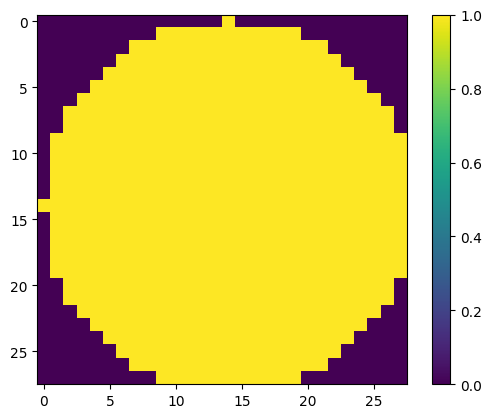

In [30]:
plt.imshow(np.angle(updated_complex_prb))
plt.colorbar()

In [31]:
updated_complex_prb_tensor = tf.convert_to_tensor(updated_complex_prb,dtype="complex64")
updated_complex_prb_tensor_tiled = tf.expand_dims(tf.tile(tf.expand_dims(updated_complex_prb, axis=0), [60000, 1, 1]),axis = 3)

In [32]:
updated_complex_prb_tensor_tiled.shape

TensorShape([60000, 28, 28, 1])

In [33]:
# exit surface wave
x_train_complex = x_train_MNIST*np.exp(1j*x_train_fMNIST) #remember that when amplitude is 0 then the phase is assumed to be 0 as well

exit_surface_wave = x_train_complex*updated_complex_prb_tensor_tiled

exit_surface_wave_amplitude = np.abs(exit_surface_wave)
exit_surface_wave_phase = np.angle(exit_surface_wave)
exit_surface_wave_phase[exit_surface_wave_amplitude == 0] = 0

updated_exit_surface_wave = exit_surface_wave_amplitude*np.exp(1j*exit_surface_wave_phase)

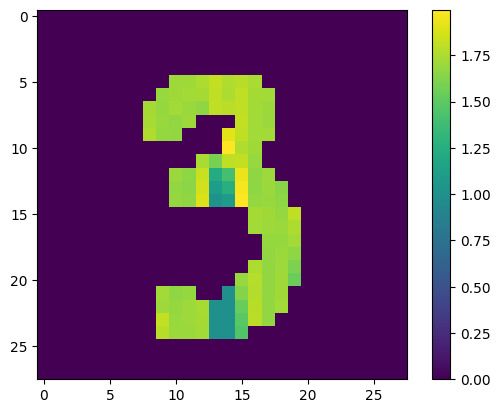

In [35]:
plt.imshow(tf.math.angle(updated_exit_surface_wave[98,:,:,:]))
plt.colorbar()

In [36]:
# squeeziamo il dataset per eliminare ultima dimensione
exit_surface_wave_squeezed = tf.squeeze(updated_exit_surface_wave)

# transformata + shift + valore assoluto
exit_surface_wave_squeezed_fft = tf.signal.fft2d(tf.cast(exit_surface_wave_squeezed,tf.complex64))
diffraction_pattern = np.abs(tf.signal.fftshift(exit_surface_wave_squeezed_fft,axes=(-2,-1)))

# unsqueeze per ritornare ad un tensore 4D digeribile dal modello
diffraction_pattern_unsqueezed = tf.expand_dims(diffraction_pattern,-1)

In [69]:
model_sequential = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        # Encoder
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2), padding="same"),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2), padding="same"),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        # layers.MaxPooling2D((2, 2), padding="same"),



        # Decoder
        layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same"),
        layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"),
        layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"),
        layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
    ]
)

model_sequential.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 conv2d_transpose_37 (Conv2D  (None, 7, 7, 64)       

## Plot tests

In [ ]:
batch_size = 128
epochs = 8

model_sequential.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)) #'binary_crossentropy' kinda works as well
model_sequential.fit(diffraction_pattern_unsqueezed, x_train_MNIST, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/8
422/422 [==============================] - 404s 955ms/step - loss: 0.1307 - val_loss: 0.1302
Epoch 2/8
422/422 [==============================] - 392s 928ms/step - loss: 0.1307 - val_loss: 0.1302
Epoch 3/8
 14/422 [..............................] - ETA: 6:08 - loss: 0.1305

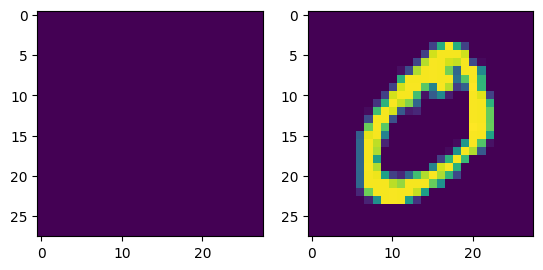

In [51]:
out_seq = model_sequential(diffraction_pattern_unsqueezed[1:10])
out_seq.shape

test_sample = 1

fig, ax = plt.subplots(1,2)
ax[0].imshow(out_seq[8])
ax[1].imshow(x_train_MNIST[1:10][0])


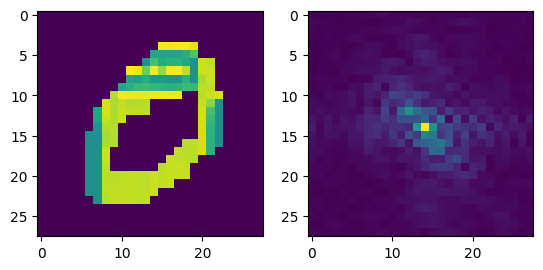

In [43]:
test_sample = 1

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.angle(exit_surface_wave_squeezed[test_sample,:,:]))
ax[1].imshow(diffraction_pattern[test_sample,:,:])

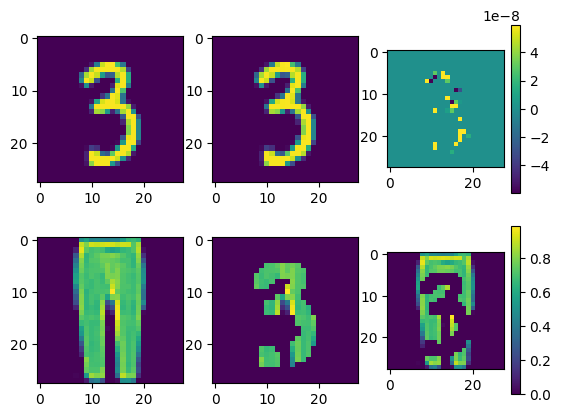

In [19]:
test_sample_phase = 98

fig, ax = plt.subplots(2,3)
ax[0,0].imshow(x_train_MNIST[test_sample_phase,:,:,:])
ax[0,1].imshow(tf.math.abs(x_train_complex[test_sample_phase,:,:,:]))
sp1 = ax[0,2].imshow(x_train_MNIST[test_sample_phase,:,:,:]-tf.math.abs(x_train_complex[test_sample_phase,:,:,:]))
ax[1,0].imshow(x_train_fMNIST[test_sample_phase,:,:,:])
ax[1,1].imshow(tf.math.angle(x_train_complex[test_sample_phase,:,:,:]))
sp2 = ax[1,2].imshow(x_train_fMNIST[test_sample_phase,:,:,:]-tf.math.angle(x_train_complex[test_sample_phase,:,:,:]))
fig.colorbar(sp2)
fig.colorbar(sp1)
